In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '../..'))
	print(os.getcwd())
except:
	pass


In [1]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro import optim
from pyro.infer import SVI, Trace_ELBO
from pyro.nn import PyroSample, PyroModule
from pyro.infer.autoguide import AutoDiagonalNormal, init_to_sample
from pyro import poutine


In [2]:
num_cl = 5
x = torch.cat((
    torch.arange(0,num_cl).unsqueeze(0),
    (torch.arange(0,num_cl).unsqueeze(0)+1) %5
))
x


tensor([[0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0]])

In [3]:
class Model(PyroModule):
    def __init__(self, num_cl):
        super().__init__()
        self.num_cl = num_cl
        self.trans_score = PyroModule[nn.Embedding](num_embeddings=self.num_cl, embedding_dim = self.num_cl)
        self.trans_score.weight = PyroSample(
            dist.Uniform(
                -2.0*torch.ones_like(self.trans_score.weight), 
                2*torch.ones_like(self.trans_score.weight)
                ).to_event(2))

    def forward2(self, x):
        state_prev = x[:,:-1]
        state_next = x[:,1:]
        logits = self.trans_score(state_prev)
        for u in pyro.plate("data_loop", len(x)):
            for t in pyro.plate(f"time_loop_{u}", state_prev.size()[1]):
                obs = pyro.sample(
                    f"obs_{u}_{t}", 
                    dist.Categorical(logits=logits[u,t,:]), 
                    obs=state_next[u,t])
        return obs

    def forward(self, x):
        state_prev = x[:,:-1]
        state_next = x[:,1:]
        time_mask = (state_prev != 1).float()
        scores = self.trans_score(state_prev)
        expscore = scores.exp()
        expscore[0,0,1] = 0#expscore[0,0,1]*0
        probs = expscore / expscore.sum(1, keepdim=True)
        #scores.size(), state_prev.size()
        
        
        #%%
        slatelen = scores.size()[-1]
        scores_flat = scores.reshape(-1, slatelen)
        target_idx_flat = state_next.reshape(-1)
        time_mask_flat = time_mask.reshape(-1)

        with pyro.plate("data_loop", size = len(target_idx_flat)):
            distr = dist.Categorical(logits=scores_flat).mask(time_mask_flat)
            obs = pyro.sample("obs", distr, obs=target_idx_flat)
        return obs


tensor([[-0.1503,  1.4150, -0.5256, -0.3267, -0.4243],
        [ 0.3866, -0.0241,  0.2534,  0.2551, -0.0438],
        [-0.4647, -0.0824, -0.3794,  1.4741, -0.3480],
        [-0.4792, -0.7448, -0.7085, -0.4717,  1.5569],
        [ 0.9522, -0.3305, -0.1632, -0.2078, -0.2447]])

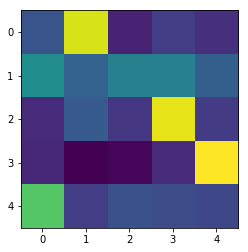

In [4]:

pyro.clear_param_store()
model = Model(num_cl)
model(x)

guide = AutoDiagonalNormal(model)
guide(x)

adam = optim.Adam({"lr": 0.1})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

for _ in range(1000):
    svi.step(x)

import matplotlib.pyplot as plt
med = guide.median()['trans_score.weight'].detach()
plt.imshow(med)
med

In [5]:
class Model(PyroModule):
    def __init__(self, num_cl):
        super().__init__()
        self.num_cl = num_cl
        self.trans_score = PyroModule[nn.Embedding](num_embeddings=self.num_cl, embedding_dim = self.num_cl)
        self.trans_score.weight = PyroSample(
            dist.Uniform(
                -2.0*torch.ones_like(self.trans_score.weight), 
                2*torch.ones_like(self.trans_score.weight)
                ).to_event(2))
    def forward(self, x):
        state_prev = x[:,:-1]
        state_next = x[:,1:]
        logits = self.trans_score(state_prev)
        for u in pyro.plate("data_loop", len(x)):
            for t in pyro.plate("time_loop", state_prev.size()[1]):
                obs = pyro.sample(
                    f"obs_{u}_{t}", 
                    dist.Categorical(logits=logits[u,t,:]), 
                    obs=state_next[u,t])
        return obs